# Customer churn prediction with ML models

This notebook aims to explore and analyze the Telco Customer Churn dataset to predict customer churn using machine learning models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Load the dataset

In [2]:
data = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### EDA

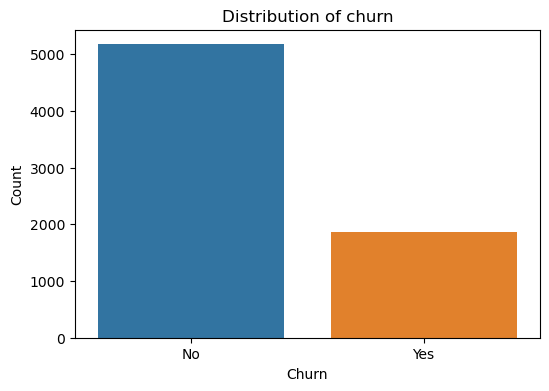

In [3]:
# Visualize distribution of target variable (Churn)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data)
plt.title('Distribution of churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

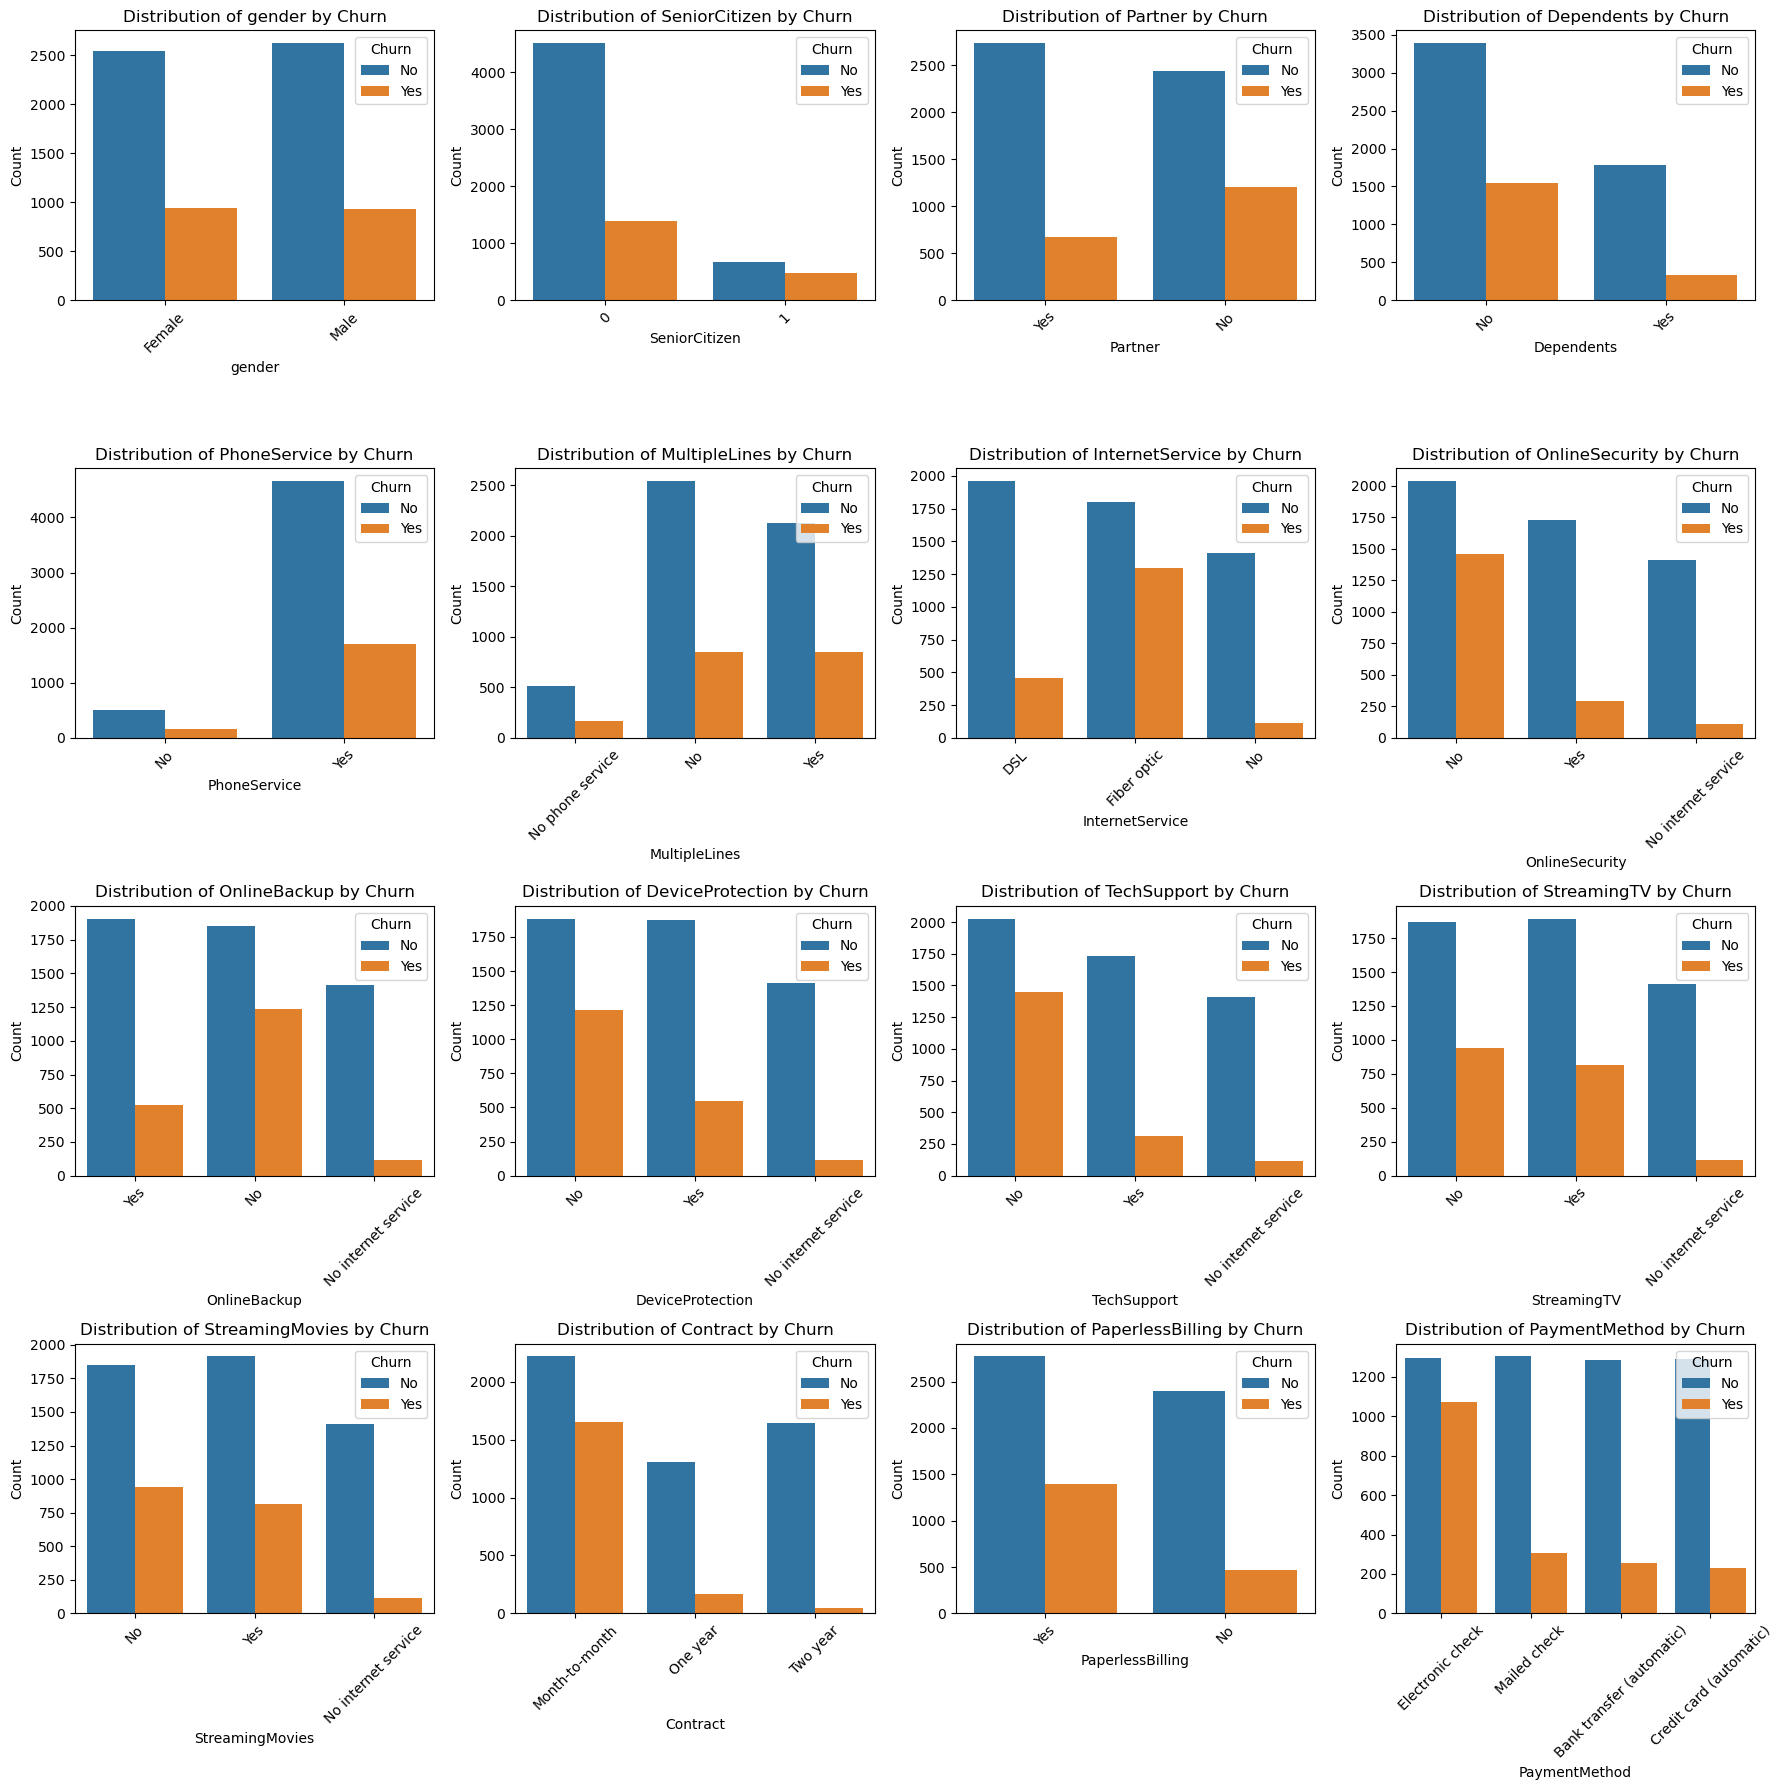

In [4]:
# Visualize distribution of categorical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Subplot dimensions
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Churn', data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Churn')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Churn', loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for i in range(len(categorical_features), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


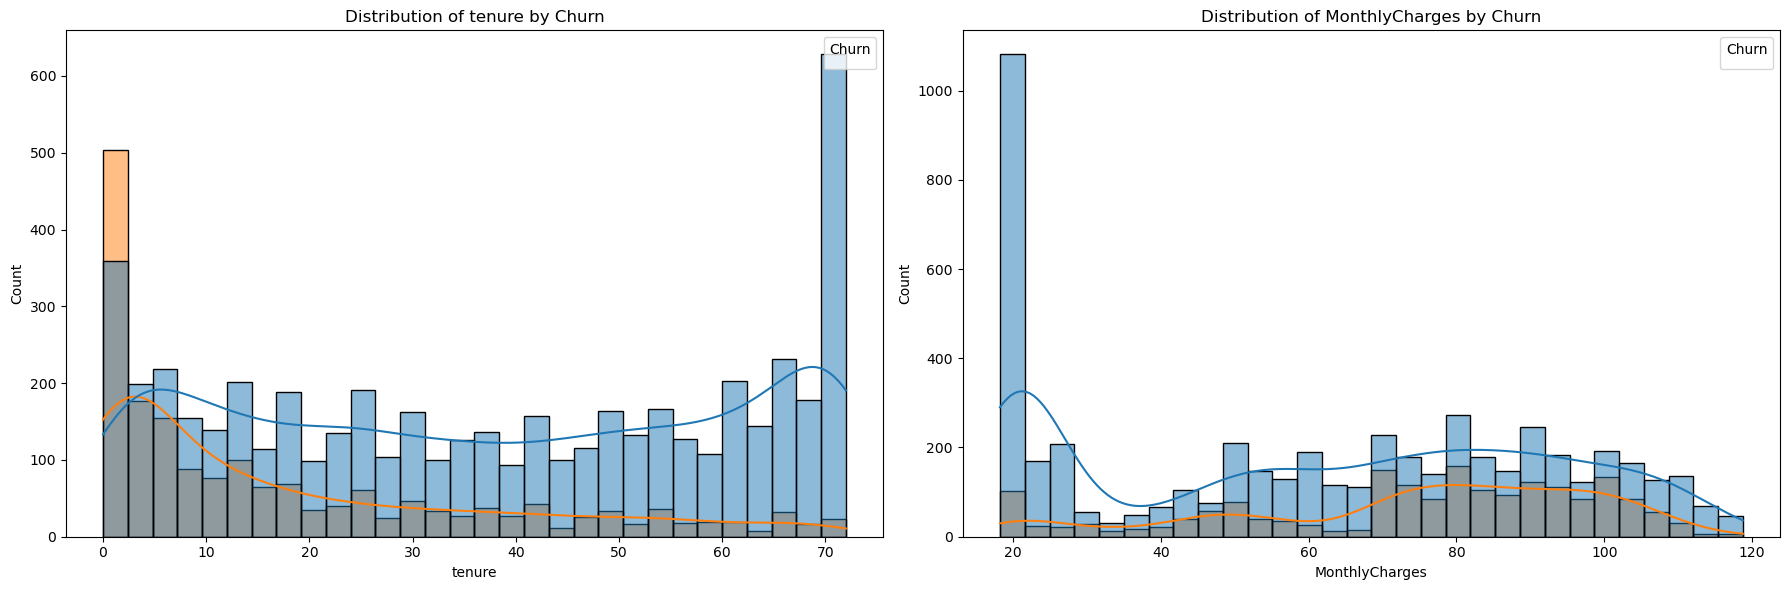

In [5]:
# Visualize distribution of numerical features
numerical_features = ['tenure', 'MonthlyCharges']

# Subplot dimensions
num_rows = 1
num_cols = len(numerical_features)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=data, x=feature, hue='Churn', kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Churn')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()

### Data preprocessing

In [6]:
# Encoding categorical variables
binary_categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
ordinal_categorical_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                                'Contract', 'PaymentMethod']

# Perform one-hot encoding for binary features
binary_encoder = OneHotEncoder(drop='first')
binary_encoded_data = binary_encoder.fit_transform(data[binary_categorical_features])
binary_encoded_columns = binary_encoder.get_feature_names_out(binary_categorical_features)

# Perform ordinal encoding for ordinal features
ordinal_encoder = OrdinalEncoder()
ordinal_encoded_data = ordinal_encoder.fit_transform(data[ordinal_categorical_features])
ordinal_encoded_columns = [f'{feature}_encoded' for feature in ordinal_categorical_features]

# Concatenate encoded binary and ordinal categorical features
encoded_data = pd.concat([pd.DataFrame(binary_encoded_data.toarray(), columns=binary_encoded_columns),
                          pd.DataFrame(ordinal_encoded_data, columns=ordinal_encoded_columns)], axis=1)

In [7]:
# Scale numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Ensure numerical features are numeric
data[numerical_features] = data[numerical_features].apply(pd.to_numeric, errors='coerce')
# Handle missing values in numerical features
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median())

scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(data[numerical_features])

# Replace original numerical features with scaled ones
for i, feature in enumerate(numerical_features):
    data[feature] = scaled_numerical_features[:, i]

In [8]:
# Encoding the target variable 'Churn'
label_encoder = LabelEncoder()
data['Churn_encoded'] = label_encoder.fit_transform(data['Churn'])

In [9]:
# Concatenate encoded categorical features and numerical features
preprocessed_data = pd.concat([encoded_data, data[numerical_features], data['Churn_encoded']], axis=1)
preprocessed_data

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_encoded,InternetService_encoded,OnlineSecurity_encoded,OnlineBackup_encoded,DeviceProtection_encoded,TechSupport_encoded,StreamingTV_encoded,StreamingMovies_encoded,Contract_encoded,PaymentMethod_encoded,tenure,MonthlyCharges,TotalCharges,Churn_encoded
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.277445,-1.160323,-0.994242,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.066327,-0.259629,-0.173244,0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.236724,-0.362660,-0.959674,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.514251,-0.746535,-0.194766,0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.236724,0.197365,-0.940470,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,3.0,-0.340876,0.665992,-0.128655,0
7039,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,1.613701,1.277533,2.243151,0
7040,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.870241,-1.168632,-0.854469,0
7041,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.155283,0.320338,-0.872062,1


#### Feature engineering

In [10]:
# Feature interaction
preprocessed_data['Tenure_MonthlyCharges_interaction'] = preprocessed_data['tenure'] * preprocessed_data['MonthlyCharges']

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[['tenure', 'MonthlyCharges']])
poly_feature_names = poly.get_feature_names(['tenure_squared', 'MonthlyCharges_squared'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
preprocessed_data = pd.concat([preprocessed_data, poly_df], axis=1)

preprocessed_data

C:\Users\israe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes,MultipleLines_encoded,InternetService_encoded,OnlineSecurity_encoded,OnlineBackup_encoded,DeviceProtection_encoded,...,tenure,MonthlyCharges,TotalCharges,Churn_encoded,Tenure_MonthlyCharges_interaction,tenure_squared,MonthlyCharges_squared,tenure_squared^2,tenure_squared MonthlyCharges_squared,MonthlyCharges_squared^2
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,-1.277445,-1.160323,-0.994242,0,1.482248,-1.277445,-1.160323,1.631865,1.482248,1.346349
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.066327,-0.259629,-0.173244,0,-0.017221,0.066327,-0.259629,0.004399,-0.017221,0.067407
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,-1.236724,-0.362660,-0.959674,1,0.448511,-1.236724,-0.362660,1.529487,0.448511,0.131523
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,...,0.514251,-0.746535,-0.194766,0,-0.383907,0.514251,-0.746535,0.264455,-0.383907,0.557315
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,-1.236724,0.197365,-0.940470,1,-0.244086,-1.236724,0.197365,1.529487,-0.244086,0.038953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,...,-0.340876,0.665992,-0.128655,0,-0.227021,-0.340876,0.665992,0.116197,-0.227021,0.443545
7039,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,...,1.613701,1.277533,2.243151,0,2.061557,1.613701,1.277533,2.604032,2.061557,1.632091
7040,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,...,-0.870241,-1.168632,-0.854469,0,1.016991,-0.870241,-1.168632,0.757319,1.016991,1.365701
7041,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,...,-1.155283,0.320338,-0.872062,1,-0.370081,-1.155283,0.320338,1.334680,-0.370081,0.102617


#### Train-test split

In [11]:
# Split the dataset into features (X) and target variable (y)
X = preprocessed_data.drop('Churn_encoded', axis=1)
y = preprocessed_data['Churn_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model training

In [12]:
# Define models
models = {
    'Logistic regression': LogisticRegression(),
    'Decision tree': DecisionTreeClassifier(),
    'Random forest': RandomForestClassifier()
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)

### Model evaluation

In [13]:
# Evaluate models
for name, model in models.items():
    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Model accuracy: {accuracy:.2f}')

    print(f'Classification report for {name} model:')
    print(classification_report(y_test, y_pred))

    print(f'Confusion matrix for {name} model:')
    print(confusion_matrix(y_test, y_pred))

Logistic regression Model accuracy: 0.81
Classification report for Logistic regression model:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.67      0.56      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409

Confusion matrix for Logistic regression model:
[[934 102]
 [163 210]]
Decision tree Model accuracy: 0.73
Classification report for Decision tree model:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1036
           1       0.49      0.52      0.50       373

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409

Confusion matrix for Decision tree model:
[[830 206]
 [178 195]]
Random forest Model accuracy: 0.80

#### Feature importance

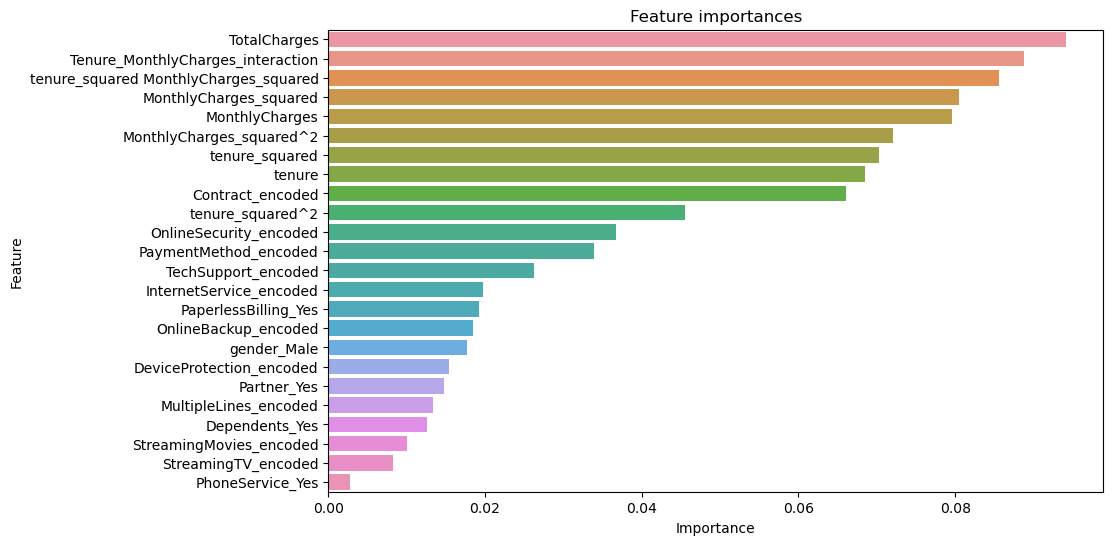

Top 5 most important features:
                                  Feature  Importance
17                           TotalCharges    0.094207
18      Tenure_MonthlyCharges_interaction    0.088720
22  tenure_squared MonthlyCharges_squared    0.085543
20                 MonthlyCharges_squared    0.080482
16                         MonthlyCharges    0.079619


In [14]:
# Feature importances for Random Forest model
feature_importances = models['Random forest'].feature_importances_

# Get feature names from preprocessed data
feature_names = X.columns

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print top 5 most important features
print("Top 5 most important features:")
print(feature_importance_df.head())

Potential next steps for improving model performance or further exploration of the dataset:

* Model tuning: We will perform hyperparameter tuning for the selected machine learning models to optimize their performance.
* Address class imbalance: We will apply techniques such as oversampling, undersampling, or using class weights to address the imbalance and improve model performance.